# Data Science Salaries - Part 2: Error Analysis and Improvements

## Error Analysis Conclusions & Work Plan

Based on the error analysis from Part 1, we identified several key issues:

- **Salary Range Bias**:
   - Model significantly underestimates high-salary positions (>250k USD)
   - Negative skew in error distribution

- **Feature Importance Issues**:
   - Employee residence dominates with ~0.40 importance score
   - Work year and remote ratio show very low importance (<0.05)
   - Potential sparsity issues with job titles

- **Experience Level Patterns**:
   - Largest error variance in Executive (EX) level
   - Significant outliers in Senior (SE) level

Loading the data & model from Part 1

In [188]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import TargetEncoder, RobustScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
import xgboost as xgb
import scipy.stats as scistats

# Set style for better visualizations
sns.set_style("whitegrid")
sns.set_palette("husl")

# Load the original data and model
path = "data\\ds_salaries.csv"
df = pd.read_csv(path)

# Import the prepare_data function from part1
from ipynb.fs.full.part1 import prepare_data, build_model

processed_data = prepare_data(df)
model, X_test, y_test, y_pred, X_train, feature_cols = build_model(processed_data)

### Root Cause Analysis

Let's analyze potential causes for the observed issues:

#### Data Distribution Problems (Data Imbalance)

Salary Distribution Statistics:
count    3755.000000
mean      137.570390
std        63.055625
min         5.132000
25%        95.000000
50%       135.000000
75%       175.000000
max       450.000000
Name: salary_in_usd, dtype: float64

Skewness: 0.54


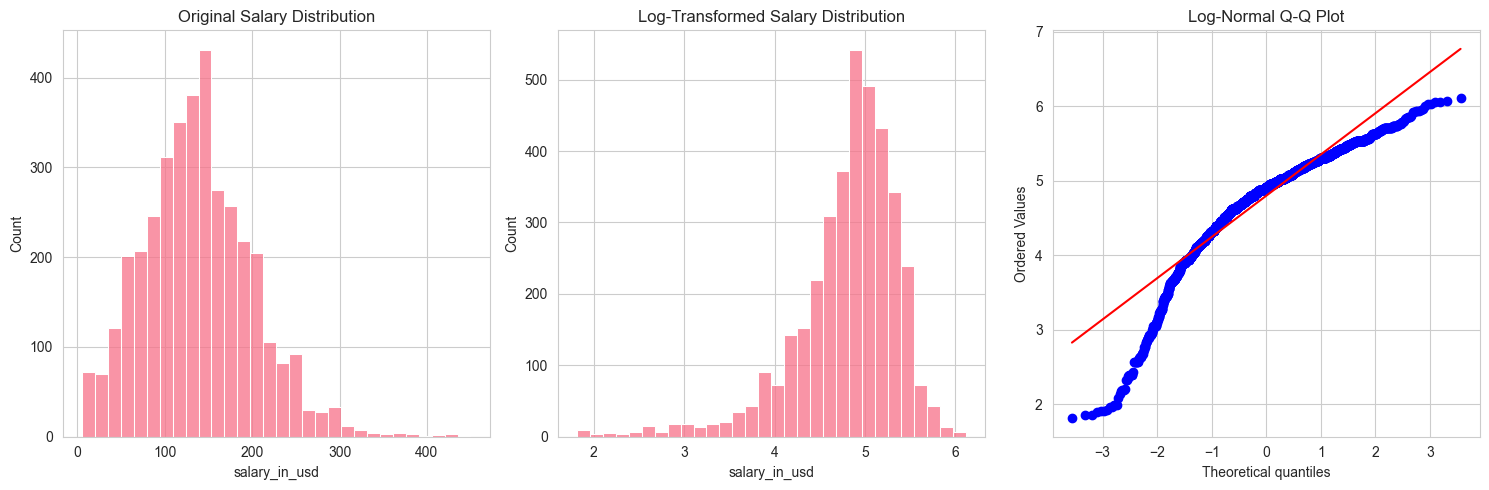

In [189]:
# # Analyze salary distribution
# plt.figure(figsize=(10, 6))
# sns.histplot(data=processed_data, x='salary_in_usd', bins=50)
# plt.title('Salary Distribution')
# plt.xlabel('Salary (thousands USD)')
# plt.ylabel('Count')
# plt.show()

# Print summary statistics
print("Salary Distribution Statistics:")
print(processed_data['salary_in_usd'].describe())

# Calculate skewness
print(f"\nSkewness: {processed_data['salary_in_usd'].skew():.2f}")

# Analyze salary distribution
plt.figure(figsize=(15, 5))
  
# Original distribution
plt.subplot(1, 3, 1)
sns.histplot(processed_data['salary_in_usd'], bins=30)
plt.title('Original Salary Distribution')
    
# Log-transformed distribution
plt.subplot(1, 3, 2)
sns.histplot(np.log1p(processed_data['salary_in_usd']), bins=30)
plt.title('Log-Transformed Salary Distribution')
    
# QQ plot for log-normality
plt.subplot(1, 3, 3)
scistats.probplot(np.log1p(processed_data['salary_in_usd']), dist="norm", plot=plt)
plt.title('Log-Normal Q-Q Plot')
    
plt.tight_layout()
plt.show()

We observe:
   - Right-skewed salary distribution
   - Underrepresentation of high-salary positions
   - Possible outliers affecting model training

**Some Potential Solutions:**
   - Custom sampling strategy based on salary ranges
   - Handle outliers
   - Consider log transformation for salary values


#### Feature Engineering Issues

In [190]:
# Analyze feature cardinality
categorical_cols = ['experience_level', 'employment_type', 'job_title', 'employee_residence', 'remote_ratio', 'company_location', 'company_size']

print("Feature Cardinality Analysis:")
for col in categorical_cols:
    unique_count = processed_data[col].nunique()
    top_5_freq = processed_data[col].value_counts().head()
    print(f"\n{col}:")
    print(f"Unique values: {unique_count}")
    print("Top 5 most frequent values:")
    print(top_5_freq)

Feature Cardinality Analysis:

experience_level:
Unique values: 4
Top 5 most frequent values:
experience_level
SE    2516
MI     805
EN     320
EX     114
Name: count, dtype: int64

employment_type:
Unique values: 4
Top 5 most frequent values:
employment_type
FT    3718
PT      17
CT      10
FL      10
Name: count, dtype: int64

job_title:
Unique values: 93
Top 5 most frequent values:
job_title
Data Engineer                1040
Data Scientist                840
Data Analyst                  612
Machine Learning Engineer     289
Analytics Engineer            103
Name: count, dtype: int64

employee_residence:
Unique values: 78
Top 5 most frequent values:
employee_residence
US    3004
GB     167
CA      85
ES      80
IN      71
Name: count, dtype: int64

remote_ratio:
Unique values: 3
Top 5 most frequent values:
remote_ratio
0      1923
100    1643
50      189
Name: count, dtype: int64

company_location:
Unique values: 72
Top 5 most frequent values:
company_location
US    3040
GB     172


We observe:
   - High cardinality (too many unique values) in categorical variables, e.g. job title or location
   - Simple label encoding might not capture relationships
   - Missing interaction effects between features
   - Overall basic feature preprocessing


**Some Potential Solutions**
- Group similar job titles
- Implement target encoding for categorical variables (crucial for high-cardinality features like job_title)
- Create experience-title interaction features (captures career progression patterns)
- Develop remote work impact factors (especially relevant in today's job market)
- Include company size-location interactions (captures market dynamics)

In [191]:
def improved_preprocessing(df):
    data = df.copy()
    
    # Create salary buckets to handle high-salary cases (outliers) better
    data['salary_bucket'] = pd.qcut(data['salary_in_usd'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
    
    # Convert salary to thousands and log transform
    data['salary_in_usd'] = data['salary_in_usd'] / 1000
    data['log_salary'] = np.log1p(data['salary_in_usd'])
    
    # Group similar job titles
    data['job_category'] = data['job_title'].apply(lambda x: 
        'Manager' if any(term in x for term in ['Manager', 'Lead', 'Head', 'Director'])
        else 'Analyst' if any(term in x for term in ['Analytics', 'Analyst', 'Strategist', 'Consultant', 'Business', 'BI'])
        else 'Scientist' if any(term in x for term in ['Scientist', 'Research', 'Researcher', 'Learning'])
        else 'Engineer' if any(term in x for term in ['Engineer', 'Developer', 'Programmer', 'Architect'])
        else 'Other')
    
    # Experience-Title Interaction Features
    exp_mapping = {
        'EN': 1,  # Entry level
        'MI': 2,  # Mid level
        'SE': 3,  # Senior
        'EX': 4   # Executive
    }
    data['experience_numeric'] = data['experience_level'].map(exp_mapping)  
    # Add TF-IDF vectorization for job titles
    tfidf = TfidfVectorizer(max_features=15)
    job_title_embeddings = tfidf.fit_transform(data['job_title']).toarray()
    for i in range(job_title_embeddings.shape[1]):
        data[f'job_title_embedding_{i}'] = job_title_embeddings[:, i]  
    for i in range(job_title_embeddings.shape[1]):  # Number of embedding dimensions
        data[f'exp_title_interaction_{i}'] = (
            data['experience_numeric'] * data[f'job_title_embedding_{i}']
        )

    # Remote Work Impact Factors
    data['remote_category'] = pd.cut(
        data['remote_ratio'],
        bins=[-1, 0, 50, 100],
        labels=['on_site', 'hybrid', 'remote']
    )
    # Calculate average salary by remote category
    remote_salary_avg = data.groupby('remote_category', observed=True)['salary_in_usd'].transform('mean')
    data['remote_salary_ratio'] = data['salary_in_usd'] / remote_salary_avg
    # Create remote-experience interaction
    data['remote_experience_interaction'] = data['remote_ratio'] * data['experience_numeric']

    # Company Size-Location Interactions
    size_mapping = {
        'S': 1,  # Small
        'M': 2,  # Medium
        'L': 3   # Large
    }
    data['size_numeric'] = data['company_size'].map(size_mapping)    
    # Calculate location-specific size impact
    size_location_avg = data.groupby(['company_location', 'company_size'])['salary_in_usd'].transform('mean')
    data['size_location_salary_ratio'] = data['salary_in_usd'] / size_location_avg
    # Create size-remote interaction
    data['size_remote_interaction'] = data['size_numeric'] * data['remote_ratio']
    
    # Target encoding
    # te = TargetEncoder()
    # categorical_cols = ['experience_level', 'employment_type', 'job_title', 'job_category', 
    #                    'employee_residence', 'company_location', 'company_size',
    #                    'salary_bucket', 'remote_category']

    # for col in categorical_cols:
    #     data[col + '_encoded'] = te.fit_transform(data[[col]], data['log_salary'])
    
    return data

## Improving Model Performance

Other than the above issues, we also observe weaknesses in the initial baseline model, which we will discuss below together with potential solutions.

#### Model Limitations
   - Linear scaling not suitable for salary ranges
   - Single model approach for all salary ranges
   - Basic validation strategy
   - Limited hyperparameter optimization
   - Loss function equally weights all errors, leading to bias towards the mean

**Model & Training Possible Improvements**
   - Use quantile regression for better uncertainty estimation
   - Use k-fold cross-validation
   - Implement hyperparameter tuning
   - Add regularization techniques, e.g. L1 (Lasso), L2 (Ridge), early stopping, feature dropout, gradient clipping
   - Use weighted sampling for underrepresented cases

#### Enhanced Data Preprocessing

In [192]:
# Apply improved preprocessing
enhanced_processed_data = improved_preprocessing(df)

categorical_cols = ['experience_level', 'employment_type', 'job_title', 'job_category', 
                    'employee_residence', 'company_location', 'company_size',
                    'salary_bucket', 'remote_category']

# Define features for modeling
feature_cols = [col for col in enhanced_processed_data.columns 
               if col in categorical_cols or
               col.endswith('_interaction') or
               col in ['work_year', 'remote_salary_ratio', 'size_location_salary_ratio']]

X = enhanced_processed_data[feature_cols]
y = enhanced_processed_data['log_salary']

#### Weighted Sampling for Underrepresented Cases

In [193]:
def calculate_sample_weights(df):
    # Get counts per bucket
    salary_counts = df['salary_bucket'].value_counts()
    
    # Print debug info
    print("Salary bucket counts:")
    print(salary_counts)
    
    # Calculate base weights - add small constant to prevent division by zero
    base_weights = np.sqrt(1 / (salary_counts + 1e-6))
    
    # Normalize weights
    weights = base_weights[df['salary_bucket']].values  # Convert to numpy array
    
    # Print debug info
    print("\nInitial weights stats:")
    print(f"Min: {weights.min()}, Max: {weights.max()}")
    
    # Scale weights 
    weights = weights / weights.sum() * len(df)
    
    # Add salary magnitude weighting
    salary_std = df['salary_in_usd'].std()
    salary_mean = df['salary_in_usd'].mean()
    
    if salary_std == 0:  # Handle edge case
        magnitude_weights = np.ones(len(df))
    else:
        magnitude_weights = 1 + 0.1 * np.abs(df['salary_in_usd'] - salary_mean) / salary_std
    
    # Combine weights
    final_weights = weights * magnitude_weights
    
    # Ensure positive weights
    final_weights = np.maximum(final_weights, 1e-6)
    
    # Final normalization
    final_weights = final_weights / final_weights.sum() * len(final_weights)
    
    # Print final stats
    print("\nFinal weights stats:")
    print(f"Min: {final_weights.min()}, Max: {final_weights.max()}")
    
    return final_weights


sample_weights = calculate_sample_weights(enhanced_processed_data)

# First do a train+validation/test split
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,
    stratify=enhanced_processed_data['salary_bucket'])

# Then split train+validation into separate train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42,  # 0.2 * 0.8 = 0.16 of total data
    stratify=enhanced_processed_data.loc[y_temp.index, 'salary_bucket'])

# Separate numerical and categorical columns 
numerical_cols = ['work_year', 'remote_salary_ratio', 'size_location_salary_ratio']
categorical_cols = ['experience_level', 'employment_type', 'job_title', 'job_category', 
                   'employee_residence', 'company_location', 'company_size',
                   'salary_bucket', 'remote_category']

# Target encoding for categorical variables
te = TargetEncoder()
X_train_encoded = pd.DataFrame(index=X_train.index)
X_val_encoded = pd.DataFrame(index=X_val.index)
X_test_encoded = pd.DataFrame(index=X_test.index)

# Encode categorical columns
for col in categorical_cols:
    # Fit only on training data
    encoded_train = te.fit_transform(X_train[[col]], y_train).ravel()
    # Transform validation and test using the same encoder
    encoded_val = te.transform(X_val[[col]]).ravel()
    encoded_test = te.transform(X_test[[col]]).ravel()
    
    X_train_encoded[col + '_encoded'] = encoded_train
    X_val_encoded[col + '_encoded'] = encoded_val
    X_test_encoded[col + '_encoded'] = encoded_test

# Add numerical columns
for col in numerical_cols:
    X_train_encoded[col] = X_train[col].values
    X_val_encoded[col] = X_val[col].values
    X_test_encoded[col] = X_test[col].values

# Scale features
scaler = RobustScaler()
X_train_scaled = X_train_encoded.copy()
X_val_scaled = X_val_encoded.copy()
X_test_scaled = X_test_encoded.copy()

# Scale numerical features
numerical_features = numerical_cols + [col for col in X_train_encoded.columns if col.endswith('_encoded')]
X_train_scaled[numerical_features] = scaler.fit_transform(X_train_encoded[numerical_features])
X_val_scaled[numerical_features] = scaler.transform(X_val_encoded[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test_encoded[numerical_features])

# Get sample weights for all splits
weights_train = sample_weights[X_train.index]
weights_val = sample_weights[X_val.index]
weights_test = sample_weights[X_test.index]

Salary bucket counts:
salary_bucket
Low          783
High         757
Very Low     751
Very High    744
Medium       720
Name: count, dtype: int64

Initial weights stats:
Min: 0.03573708447177255, Max: 0.03726779959911608

Final weights stats:
Min: 0.9340749348805051, Max: 1.3941883166595612


#### Hyperparameter Tuning with Cross-Validation

In [194]:
# Define parameter grid for RandomizedSearchCV
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.1, 0.5, 1.0]
}

# Initialize base model
base_model = xgb.XGBRegressor(
    objective='reg:quantileerror',
    quantile_alpha=0.5,
    random_state=42
)

# Set up K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform RandomizedSearchCV with both train and validation sets
random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_grid,
    n_iter=100,
    scoring='neg_mean_squared_error',
    cv=kf,
    random_state=42,
    n_jobs=-1
)

# Fit only with basic parameters
random_search.fit(
    X_train_scaled, 
    y_train,
    sample_weight=weights_train
)

print("Best parameters found:")
for param, value in random_search.best_params_.items():
    print(f"{param}: {value}")

Best parameters found:
subsample: 0.8
reg_lambda: 0.1
reg_alpha: 0.5
n_estimators: 300
min_child_weight: 7
max_depth: 7
learning_rate: 0.1
gamma: 0.1
colsample_bytree: 1.0


#### Training Final Model with Quantile Regression

In [195]:
# Train models for different quantiles
quantiles = [0.1, 0.5, 0.9]
quantile_models = {}

for q in quantiles:
    model = xgb.XGBRegressor(
        objective='reg:quantileerror',
        quantile_alpha=q,
        **random_search.best_params_,
        random_state=42
    )
    
    # Convert pandas DataFrames to numpy arrays
    X_train_array = X_train_scaled.to_numpy()
    y_train_array = y_train.to_numpy()
    X_val_array = X_val_scaled.to_numpy()
    y_val_array = y_val.to_numpy()
    
    # Create DMatrix objects
    dtrain = xgb.DMatrix(X_train_array, label=y_train_array, weight=weights_train)
    dval = xgb.DMatrix(X_val_array, label=y_val_array)
    
    # Setup evaluation watchlist
    eval_list = [(dtrain, 'train'), (dval, 'validation')]
    
    # Train the model
    model.fit(
        X_train_array,
        y_train_array,
        sample_weight=weights_train,
        eval_set=[(X_val_array, y_val_array)],
        verbose=False
    )
    
    quantile_models[q] = model

# Make predictions for each quantile
predictions = {}
for q, model in quantile_models.items():
    predictions[q] = model.predict(X_test_scaled)
